Upgrade tensorflow and keras and install keras_nlp for transformer network.

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras
!pip install keras_nlp

Download the dataset.

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1ppZQlLDZ54OQNHTyuuJoHeMbt5UcCZba" -O /kaggle/working/train.tsv.zip

In [ ]:
!mkdir data
!unzip train.tsv.zip -d data

Import the necessary libraries

In [ ]:
import gc
import os
import numpy as np
import pandas as pd
import nltk
import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
lemmatizer = WordNetLemmatizer()
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import plot_model
from wordcloud import WordCloud

Read the data into pandas dataframe

In [5]:
train_sentences = pd.read_csv(
    'data/train.tsv',
    dtype={
        'PhraseId': 'int32',
        'SentenceId': 'int16',
        'Phrase': 'str',
        'Sentiment': 'int8',
    },
    sep='\t'
)

Here we can see the dataset

In [6]:
train_sentences

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [7]:
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

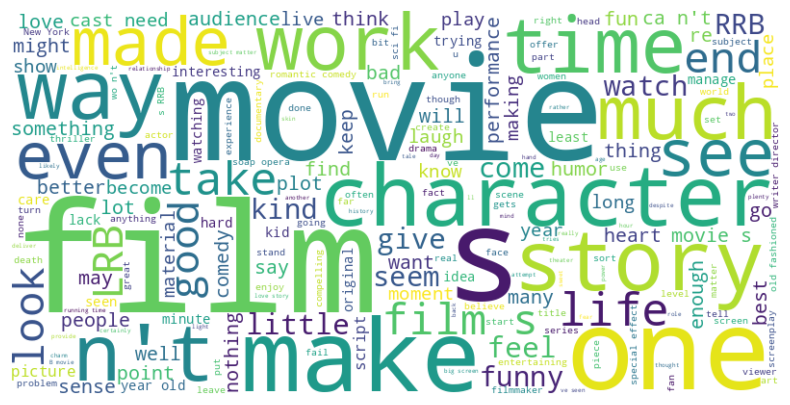

In [13]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(train_sentences['Phrase']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

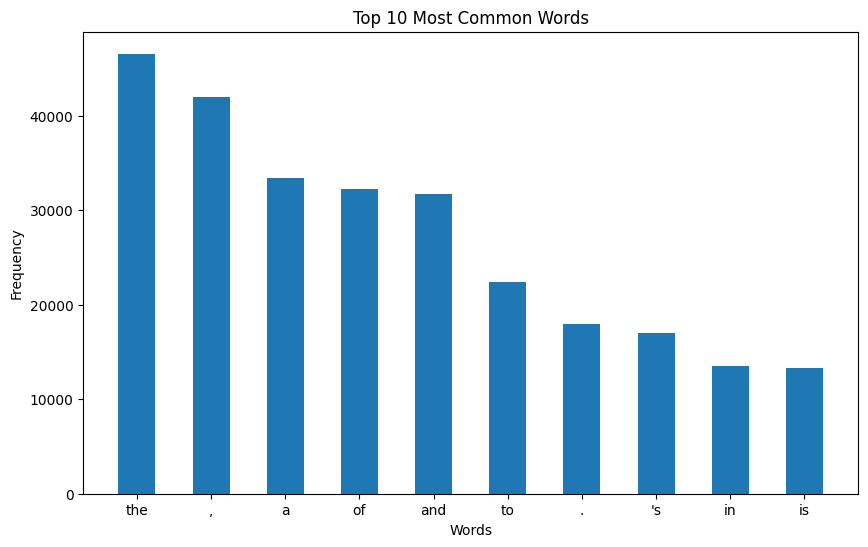

In [14]:
text = ' '.join(train_sentences['Phrase'])
tokenized_text = word_tokenize(text)
freq_dist = FreqDist(tokenized_text)

top_words = freq_dist.most_common(10)
labels, counts = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, width=0.5)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.show()

In [15]:
wordnet_mapping = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    return [lemmatizer.lemmatize(word, wordnet_mapping.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text]

In [16]:
stop_words = set(stopwords.words('english'))

def pre_process(df):
    reviews = []
    for sentence in df['Phrase']:
        sentence = sentence.lower()
        sentence = ''.join([c for c in sentence if c not in punctuation])
        words = word_tokenize(sentence)
        words = [word for word in words if word not in stop_words]
        lemma_words = lemmatize_words(words)
        reviews.append(lemma_words)
    return reviews

In [17]:
train_sentences_processed = pre_process(train_sentences)
train_sentences_processed[0]

['series',
 'escapades',
 'demonstrating',
 'adage',
 'good',
 'goose',
 'also',
 'good',
 'gander',
 'occasionally',
 'amuse',
 'none',
 'amount',
 'much',
 'story']

In [18]:
label = train_sentences['Sentiment']
target = to_categorical(label)

In [19]:
print(target[0])
print(label[0])

[0. 1. 0. 0. 0.]
1


In [20]:
x_train, x, y_train, y = train_test_split(train_sentences_processed, target, test_size=0.3, stratify=target)
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5, stratify=y)

In [21]:
print(len(x_train))
print(len(x_val))
print(len(x_test))

109242
23409
23409


In [22]:
unique_words = set()
len_max = 0

for sent in x_train:
    unique_words.update(sent)

    if(len_max<len(sent)):
        len_max = len(sent)

print(len(list(unique_words)))
print(len_max)

14379
28


In [23]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train))

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = sequence.pad_sequences(x_train, maxlen=len_max, padding="post")
x_val = sequence.pad_sequences(x_val, maxlen=len_max, padding="post")
x_test = sequence.pad_sequences(x_test, maxlen=len_max, padding="post")

In [24]:
print(x_train.shape,x_val.shape,x_test.shape)

(109242, 28) (23409, 28) (23409, 28)


## LSTM

In [39]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'min', monitor='val_loss', patience = 5)
checkpoint = ModelCheckpoint('best_model_LSTM.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callback = [early_stopping, checkpoint]

num_classes=target.shape[1]

In [40]:
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(Bidirectional(LSTM(128,dropout=0.5, return_sequences=True)))
model.add(Bidirectional(LSTM(64,dropout=0.5, return_sequences=False)))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 28, 300)           4313700   
                                                                 
 bidirectional_8 (Bidirecti  (None, 28, 256)           439296    
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 100)               12900     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 5)                

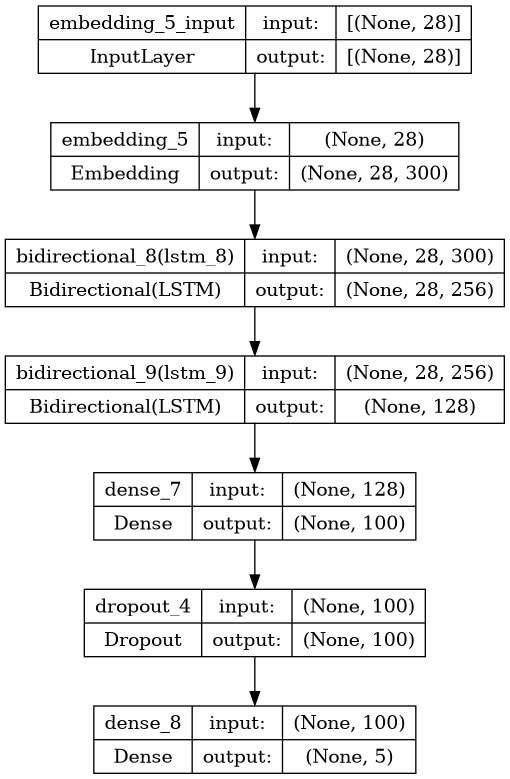

In [116]:
plot_model(model, "LSTM.png", show_shapes=True)

In [42]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=256, verbose=1, callbacks=callback)

model.load_weights('best_model_LSTM.h5')

Epoch 1/20
427/427 [==============================] - ETA: 0s - loss: 1.0726 - accuracy: 0.5741
Epoch 1: val_loss improved from inf to 0.90693, saving model to best_model_LSTM.h5
427/427 [==============================] - 70s 147ms/step - loss: 1.0726 - accuracy: 0.5741 - val_loss: 0.9069 - val_accuracy: 0.6329
Epoch 2/20
  1/427 [..............................] - ETA: 17s - loss: 0.9241 - accuracy: 0.6133

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


427/427 [==============================] - ETA: 0s - loss: 0.8437 - accuracy: 0.6587
Epoch 2: val_loss improved from 0.90693 to 0.86520, saving model to best_model_LSTM.h5
427/427 [==============================] - 27s 63ms/step - loss: 0.8437 - accuracy: 0.6587 - val_loss: 0.8652 - val_accuracy: 0.6500
Epoch 3/20
427/427 [==============================] - ETA: 0s - loss: 0.7750 - accuracy: 0.6830
Epoch 3: val_loss improved from 0.86520 to 0.84610, saving model to best_model_LSTM.h5
427/427 [==============================] - 22s 51ms/step - loss: 0.7750 - accuracy: 0.6830 - val_loss: 0.8461 - val_accuracy: 0.6602
Epoch 4/20
427/427 [==============================] - ETA: 0s - loss: 0.7285 - accuracy: 0.7002
Epoch 4: val_loss did not improve from 0.84610
427/427 [==============================] - 20s 47ms/step - loss: 0.7285 - accuracy: 0.7002 - val_loss: 0.8519 - val_accuracy: 0.6579
Epoch 5/20
427/427 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.7122
Epoch 5

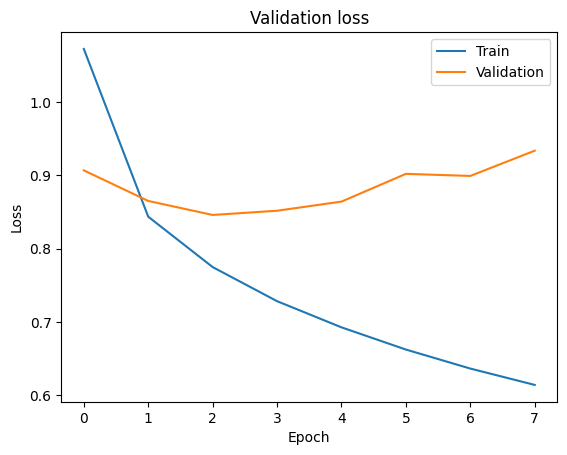

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [44]:
results = model.evaluate(x_test, y_test)

732/732 [==============================] - 4s 5ms/step - loss: 0.8474 - accuracy: 0.6532


## GRU

In [45]:
from keras.layers import GRU

checkpoint = ModelCheckpoint('best_model_GRU.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='mim')
callback = [early_stopping, checkpoint]

model1=Sequential()
model1.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model1.add(Bidirectional(GRU(128,dropout=0.5, return_sequences=True)))
model1.add(Bidirectional(GRU(64,dropout=0.5, return_sequences=False)))
model1.add(Dense(100,activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(num_classes,activation='softmax'))
model1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 28, 300)           4313700   
                                                                 
 bidirectional_10 (Bidirect  (None, 28, 256)           330240    
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 128)               123648    
 ional)                                                          
                                                                 
 dense_9 (Dense)             (None, 100)               12900     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 5)                

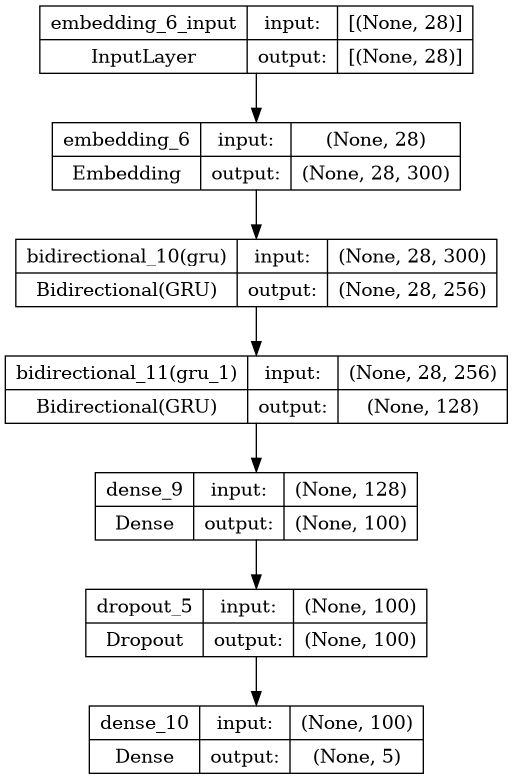

In [46]:
plot_model(model1, "GRU.png", show_shapes=True)

In [47]:
history1=model1.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=20, batch_size=256, verbose=1, callbacks=callback)

model1.load_weights('best_model_GRU.h5')

Epoch 1/20
427/427 [==============================] - ETA: 0s - loss: 1.0393 - accuracy: 0.5836
Epoch 1: val_loss improved from inf to 0.89057, saving model to best_model_GRU.h5
427/427 [==============================] - 57s 117ms/step - loss: 1.0393 - accuracy: 0.5836 - val_loss: 0.8906 - val_accuracy: 0.6398
Epoch 2/20
  1/427 [..............................] - ETA: 17s - loss: 0.9295 - accuracy: 0.6094

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


427/427 [==============================] - ETA: 0s - loss: 0.8302 - accuracy: 0.6630
Epoch 2: val_loss improved from 0.89057 to 0.86061, saving model to best_model_GRU.h5
427/427 [==============================] - 24s 56ms/step - loss: 0.8302 - accuracy: 0.6630 - val_loss: 0.8606 - val_accuracy: 0.6517
Epoch 3/20
427/427 [==============================] - ETA: 0s - loss: 0.7586 - accuracy: 0.6888
Epoch 3: val_loss improved from 0.86061 to 0.84374, saving model to best_model_GRU.h5
427/427 [==============================] - 20s 47ms/step - loss: 0.7586 - accuracy: 0.6888 - val_loss: 0.8437 - val_accuracy: 0.6608
Epoch 4/20
427/427 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.7048
Epoch 4: val_loss did not improve from 0.84374
427/427 [==============================] - 19s 45ms/step - loss: 0.7110 - accuracy: 0.7048 - val_loss: 0.8569 - val_accuracy: 0.6572
Epoch 5/20
427/427 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.7165
Epoch 5: 

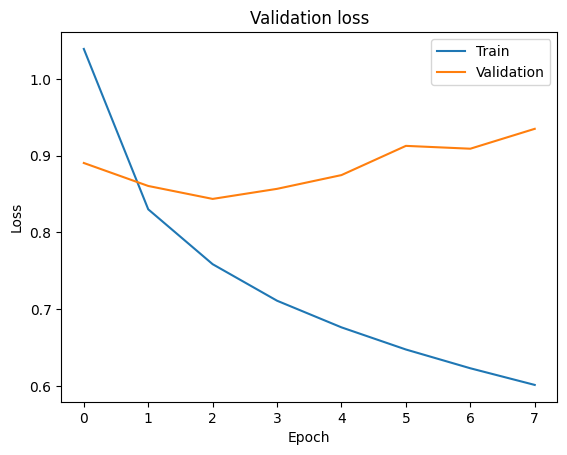

In [129]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

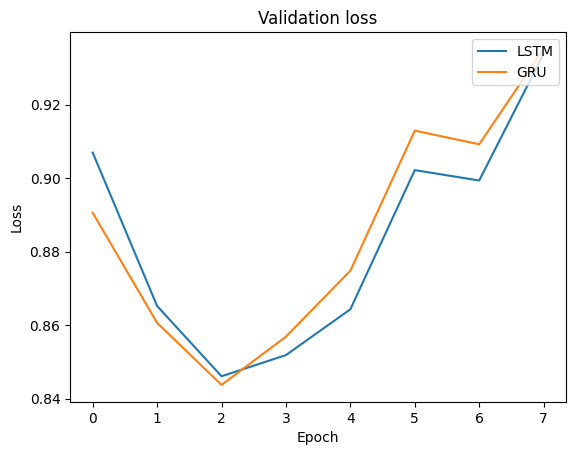

In [135]:
plt.plot(history.history['val_loss'])
plt.plot(history1.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'GRU'], loc='upper right')
plt.show()

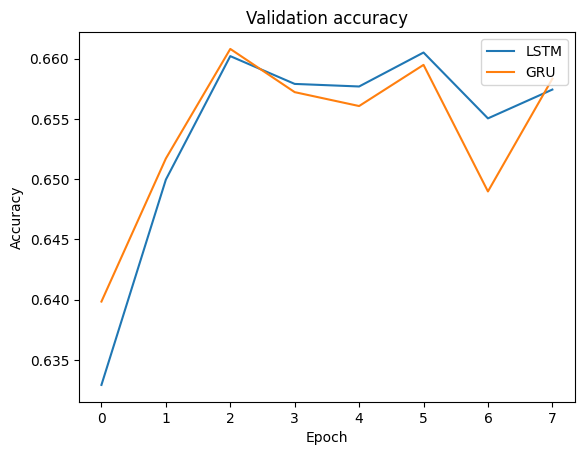

In [128]:
plt.plot(history.history['val_accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'GRU'], loc='upper right')
plt.show()

In [50]:
results1 = model1.evaluate(x_test, y_test)

732/732 [==============================] - 4s 5ms/step - loss: 0.8440 - accuracy: 0.6568


## Conv + LSTM

In [51]:
from keras.layers import Conv1D, MaxPooling1D

checkpoint = ModelCheckpoint('best_model_CNN_LSTM.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callback = [early_stopping, checkpoint]

model2=Sequential()
model2.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model2.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Bidirectional(LSTM(128, dropout=0.3, return_sequences=False)))
model2.add(Dropout(0.3))
model2.add(Dense(num_classes,activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 28, 300)           4313700   
                                                                 
 conv1d (Conv1D)             (None, 28, 64)            57664     
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 64)            0         
 D)                                                              
                                                                 
 bidirectional_12 (Bidirect  (None, 256)               197632    
 ional)                                                          
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 5)                

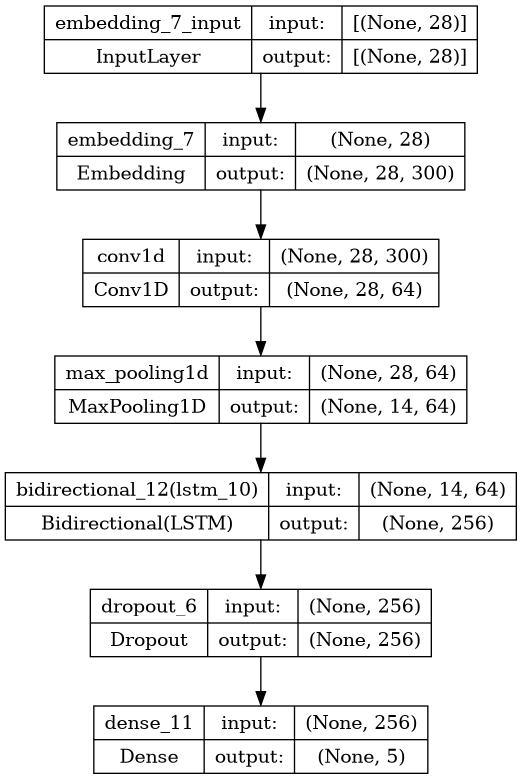

In [52]:
plot_model(model2, "CNN_LSTM.png", show_shapes=True)

In [53]:
history2=model2.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=20, batch_size=256, verbose=1, callbacks=callback)

model2.load_weights('best_model_CNN_LSTM.h5')

Epoch 1/20
427/427 [==============================] - ETA: 0s - loss: 1.0331 - accuracy: 0.5864
Epoch 1: val_loss improved from inf to 0.88693, saving model to best_model_CNN_LSTM.h5
427/427 [==============================] - 55s 108ms/step - loss: 1.0331 - accuracy: 0.5864 - val_loss: 0.8869 - val_accuracy: 0.6407
Epoch 2/20
  1/427 [..............................] - ETA: 15s - loss: 0.9101 - accuracy: 0.6133

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


427/427 [==============================] - ETA: 0s - loss: 0.8093 - accuracy: 0.6696
Epoch 2: val_loss improved from 0.88693 to 0.85949, saving model to best_model_CNN_LSTM.h5
427/427 [==============================] - 20s 48ms/step - loss: 0.8093 - accuracy: 0.6696 - val_loss: 0.8595 - val_accuracy: 0.6491
Epoch 3/20
427/427 [==============================] - ETA: 0s - loss: 0.7222 - accuracy: 0.6999
Epoch 3: val_loss improved from 0.85949 to 0.84793, saving model to best_model_CNN_LSTM.h5
427/427 [==============================] - 17s 39ms/step - loss: 0.7222 - accuracy: 0.6999 - val_loss: 0.8479 - val_accuracy: 0.6598
Epoch 4/20
427/427 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.7232
Epoch 4: val_loss did not improve from 0.84793
427/427 [==============================] - 16s 36ms/step - loss: 0.6614 - accuracy: 0.7232 - val_loss: 0.8658 - val_accuracy: 0.6596
Epoch 5/20
427/427 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.7410

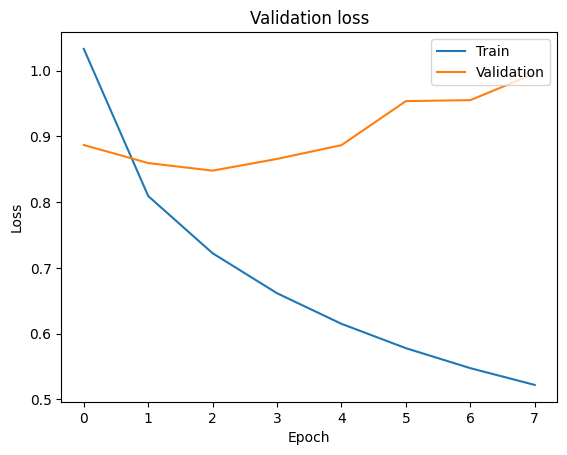

In [131]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [55]:
results2 = model2.evaluate(x_test, y_test)

732/732 [==============================] - 3s 3ms/step - loss: 0.8501 - accuracy: 0.6555


## GLOVE

In [56]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-12-04 22:03:56--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-12-04 22:03:56--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-04 22:03:56--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [57]:
path_to_glove_file = os.path.join("glove.6B.300d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [58]:
num_tokens = len(tokenizer.word_index) + 2
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 12657 words (1722 misses)


In [59]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

checkpoint = ModelCheckpoint('best_model_GLOVE.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callback = [early_stopping, checkpoint]

model3 = Sequential()
model3.add(embedding_layer)
model3.add(Bidirectional(LSTM(128,dropout=0.5, return_sequences=True)))
model3.add(Bidirectional(LSTM(64,dropout=0.5, return_sequences=False)))
model3.add(Dense(100,activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(num_classes,activation='softmax'))
model3.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 300)         4314300   
                                                                 
 bidirectional_13 (Bidirect  (None, None, 256)         439296    
 ional)                                                          
                                                                 
 bidirectional_14 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dense_12 (Dense)            (None, 100)               12900     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 5)                

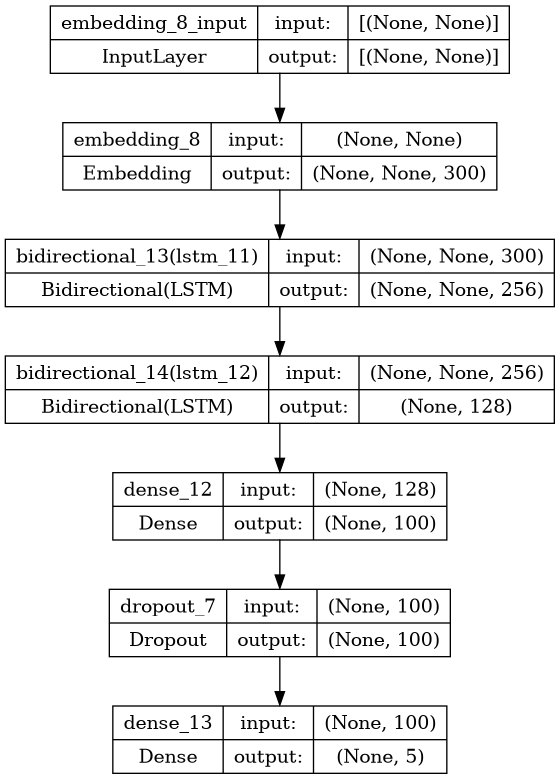

In [117]:
plot_model(model3, "LSTM_GLOVE.png", show_shapes=True)

In [60]:
history3=model3.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=20, batch_size=256, verbose=1, callbacks=callback)

model3.load_weights('best_model_GLOVE.h5')

Epoch 1/20
425/427 [============================>.] - ETA: 0s - loss: 1.0538 - accuracy: 0.5736
Epoch 1: val_loss improved from inf to 0.96035, saving model to best_model_GLOVE.h5
427/427 [==============================] - 29s 51ms/step - loss: 1.0537 - accuracy: 0.5737 - val_loss: 0.9603 - val_accuracy: 0.6045
Epoch 2/20
427/427 [==============================] - ETA: 0s - loss: 0.9818 - accuracy: 0.5988
Epoch 2: val_loss improved from 0.96035 to 0.93557, saving model to best_model_GLOVE.h5
427/427 [==============================] - 20s 47ms/step - loss: 0.9818 - accuracy: 0.5988 - val_loss: 0.9356 - val_accuracy: 0.6138
Epoch 3/20
425/427 [============================>.] - ETA: 0s - loss: 0.9523 - accuracy: 0.6128
Epoch 3: val_loss improved from 0.93557 to 0.90913, saving model to best_model_GLOVE.h5
427/427 [==============================] - 20s 47ms/step - loss: 0.9523 - accuracy: 0.6127 - val_loss: 0.9091 - val_accuracy: 0.6273
Epoch 4/20
427/427 [==============================] -

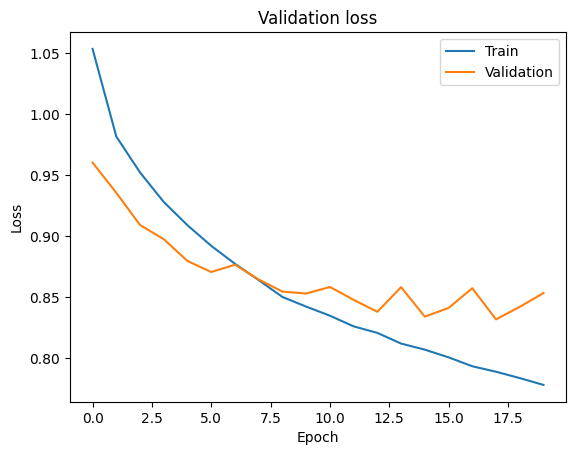

In [132]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [62]:
results3 = model3.evaluate(x_test, y_test)

732/732 [==============================] - 4s 5ms/step - loss: 0.8284 - accuracy: 0.6594


## Word2Vec

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

In [ ]:
!unzip wiki-news-300d-1M.vec.zip

In [10]:
from gensim.models import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

In [11]:
word_vectors.most_similar('film')

[('movie', 0.8515858054161072),
 ('films', 0.806742787361145),
 ('Film', 0.7176781296730042),
 ('movies', 0.6983358263969421),
 ('soundtrack', 0.6947436928749084),
 ('filmmaker', 0.6937269568443298),
 ('filmmaking', 0.6870395541191101),
 ('cinema', 0.6867582201957703),
 ('film-', 0.6740697622299194),
 ('filmmakers', 0.673538863658905)]

In [25]:
num_tokens = len(tokenizer.word_index) + 2
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 12299 words (2080 misses)


In [35]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

checkpoint = ModelCheckpoint('best_model_WORD2VEC.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callback = [early_stopping, checkpoint]

model4 = Sequential()
model4.add(embedding_layer)
model4.add(Bidirectional(LSTM(128,dropout=0.5, return_sequences=True)))
model4.add(Bidirectional(LSTM(64,dropout=0.5, return_sequences=False)))
model4.add(Dense(100,activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(num_classes,activation='softmax'))
model4.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 300)         4314300   
                                                                 
 bidirectional_6 (Bidirecti  (None, None, 256)         439296    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 100)               12900     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 5)                

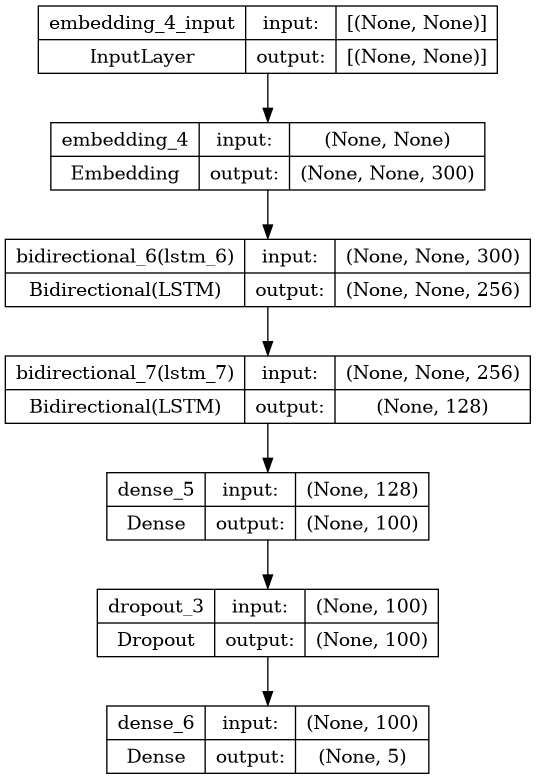

In [118]:
plot_model(model4, "LSTM_Word2Vec.png", show_shapes=True)

In [36]:
history4=model4.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=20, batch_size=256, verbose=1, callbacks=callback)

model4.load_weights('best_model_WORD2VEC.h5')

Epoch 1/20
426/427 [============================>.] - ETA: 0s - loss: 1.0393 - accuracy: 0.5800
Epoch 1: val_loss improved from inf to 0.95036, saving model to best_model_WORD2VEC.h5
427/427 [==============================] - 29s 51ms/step - loss: 1.0392 - accuracy: 0.5800 - val_loss: 0.9504 - val_accuracy: 0.6081
Epoch 2/20
425/427 [============================>.] - ETA: 0s - loss: 0.9733 - accuracy: 0.6022
Epoch 2: val_loss improved from 0.95036 to 0.92993, saving model to best_model_WORD2VEC.h5
427/427 [==============================] - 20s 47ms/step - loss: 0.9732 - accuracy: 0.6021 - val_loss: 0.9299 - val_accuracy: 0.6163
Epoch 3/20
424/427 [============================>.] - ETA: 0s - loss: 0.9566 - accuracy: 0.6090
Epoch 3: val_loss improved from 0.92993 to 0.91970, saving model to best_model_WORD2VEC.h5
427/427 [==============================] - 20s 47ms/step - loss: 0.9567 - accuracy: 0.6090 - val_loss: 0.9197 - val_accuracy: 0.6189
Epoch 4/20
424/427 [========================

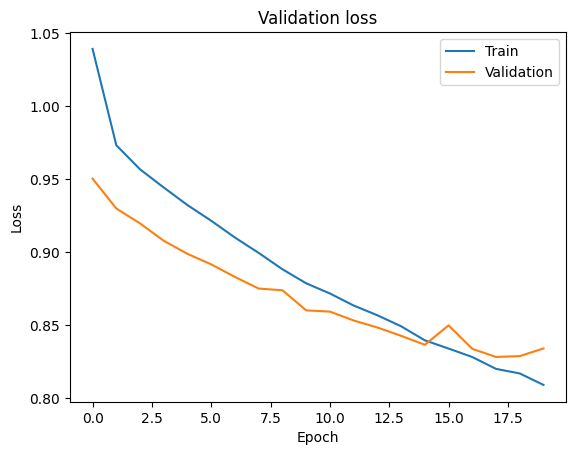

In [133]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [38]:
results4 = model4.evaluate(x_test, y_test)

732/732 [==============================] - 4s 5ms/step - loss: 0.8275 - accuracy: 0.6594


## BERT

In [63]:
import keras
import keras_nlp
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

Using TensorFlow backend


In [64]:
keras.mixed_precision.set_global_policy("mixed_float16")

In [ ]:
X = train_sentences["Phrase"]
y = train_sentences["Sentiment"]

X_train, X, y_train, y = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

In [66]:
X_train

72476     sure what -- and has all the dramatic weight o...
133360    , the tale has turned from sweet to bitterswee...
99049                             Monty formula mercilessly
11985     Proves a lovely trifle that , unfortunately , ...
6220                              Feral and uncomfortable .
                                ...                        
142974    Laced with liberal doses of dark humor , gorge...
130583                                            unrelated
7375                           Ivan is a prince of a fellow
115288                        the stomach-knotting suspense
3752                                              scrapbook
Name: Phrase, Length: 109242, dtype: object

In [67]:
y_train

72476     1
133360    4
99049     2
11985     1
6220      1
         ..
142974    4
130583    1
7375      3
115288    3
3752      2
Name: Sentiment, Length: 109242, dtype: int8

In [79]:
preset= "distil_bert_base_en_uncased"

preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_reviews"
                                                                  )

classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=5)

classifier.summary()

Preprocessor: "preprocessor_4_reviews"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer_3 (DistilBertTokenizer)      │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone_3 (DistilBertBackbone)   │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem_3 (SlicingOpLambda)  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 5)                              │           3,845 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,957,317 (255.42 MB)

 Trainable params: 66,957,317 (255.42 MB)

 Non-trainable params: 0 (0.00 B)

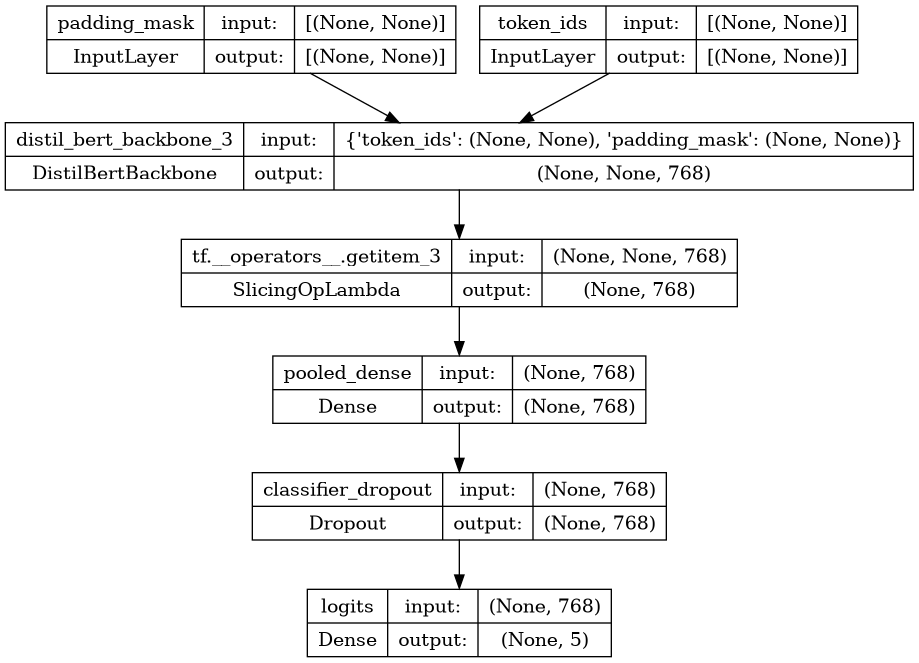

In [119]:
plot_model(classifier, "BERT.png", show_shapes=True)

In [80]:
BATCH_SIZE = 64
EPOCHS = 5

early_stopping_for_bert = EarlyStopping(min_delta = 0.001, mode = 'min', monitor='val_loss', patience = 2)
callback = [early_stopping_for_bert]

classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)

history5 = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val),
                         verbose=1,
                         callbacks=callback
                        )

Epoch 1/5
1707/1707 [==============================] - 862s 492ms/step - loss: 0.8706 - accuracy: 0.6436 - val_loss: 0.7666 - val_accuracy: 0.6790
Epoch 2/5
1707/1707 [==============================] - 769s 451ms/step - loss: 0.7382 - accuracy: 0.6930 - val_loss: 0.7436 - val_accuracy: 0.6934
Epoch 3/5
1707/1707 [==============================] - 769s 450ms/step - loss: 0.6821 - accuracy: 0.7170 - val_loss: 0.7375 - val_accuracy: 0.6930
Epoch 4/5
1707/1707 [==============================] - 769s 450ms/step - loss: 0.6406 - accuracy: 0.7369 - val_loss: 0.7499 - val_accuracy: 0.6923
Epoch 5/5
1707/1707 [==============================] - 768s 450ms/step - loss: 0.6081 - accuracy: 0.7508 - val_loss: 0.7670 - val_accuracy: 0.6865


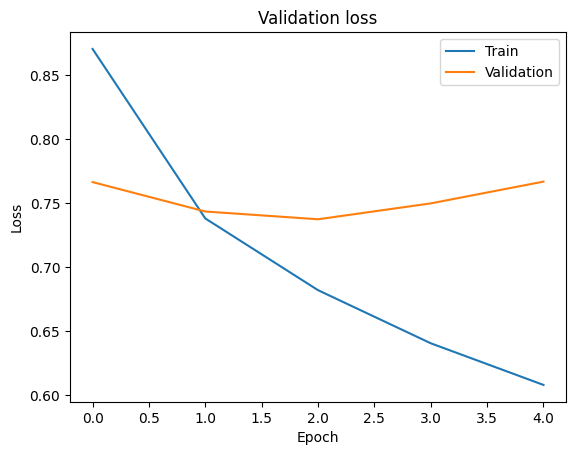

In [134]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [87]:
results5 = classifier.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

366/366 [==============================] - 62s 167ms/step - loss: 0.7674 - accuracy: 0.6884


In [101]:
prediction = classifier.predict(X_test)

732/732 [==============================] - 75s 101ms/step


In [104]:
predictionForBert = np.argmax(prediction, axis=1)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

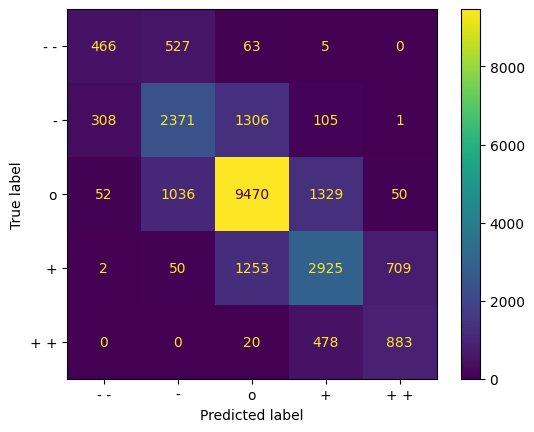

In [113]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, predictionForBert)

# -- negative, - somewhat negative, o neutral, + somewhat positive, ++ positive
class_names = ['- -', '-', 'o', '+', '+ +']

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)

cm_display.plot()
plt.show() 

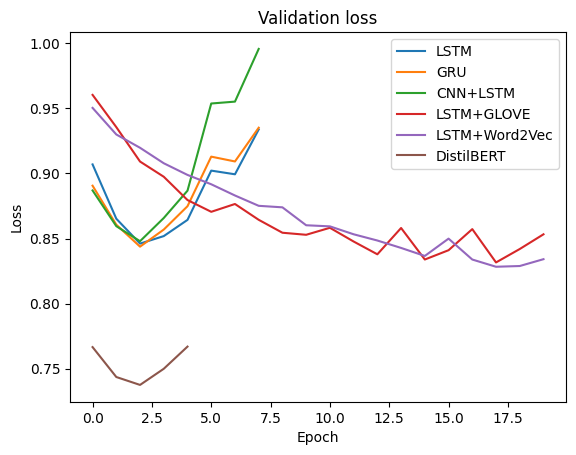

In [114]:
plt.plot(history.history['val_loss'])
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.plot(history5.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'GRU', 'CNN+LSTM', 'LSTM+GLOVE', 'LSTM+Word2Vec', 'DistilBERT'], loc='upper right')
plt.show()

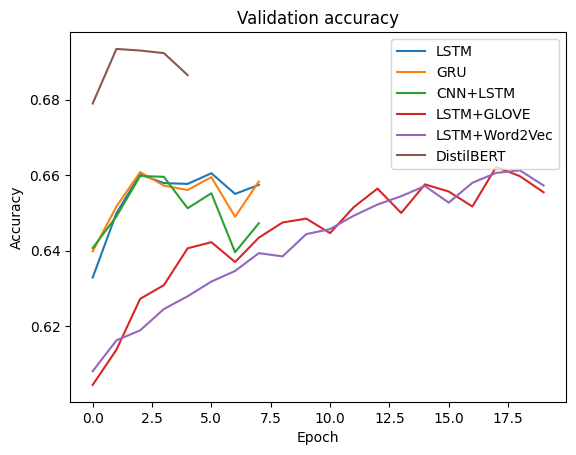

In [122]:
plt.plot(history.history['val_accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['LSTM', 'GRU', 'CNN+LSTM', 'LSTM+GLOVE', 'LSTM+Word2Vec', 'DistilBERT'], loc='upper right')
plt.show()